In [349]:
# id with 0 = depot
nodes = [
    { 'id': 0, 'latitude': 4.4184, 'longitude': 114.0932, 'demand': 0 },
    { 'id': 1, 'latitude': 4.3555, 'longitude': 113.9777, 'demand': 5 },
    { 'id': 2, 'latitude': 4.3976, 'longitude': 114.0049, 'demand': 8 },
    { 'id': 3, 'latitude': 4.3163, 'longitude': 114.0764, 'demand': 3 },
    { 'id': 4, 'latitude': 4.3184, 'longitude': 113.9932, 'demand': 6 },
    { 'id': 5, 'latitude': 4.4024, 'longitude': 113.9932, 'demand': 5 },
    { 'id': 6, 'latitude': 4.4142, 'longitude': 113.9896, 'demand': 8 },
    { 'id': 7, 'latitude': 4.4804, 'longitude': 114.0127, 'demand': 3 },
    { 'id': 8, 'latitude': 4.3818, 'longitude': 114.0734, 'demand': 6 },
    { 'id': 9, 'latitude': 4.4935, 'longitude': 114.2034, 'demand': 5 },
    { 'id': 10, 'latitude': 4.4932, 'longitude': 114.1322, 'demand': 8 },
]

vehicles = [
    { 'vehicle': 'A', 'maximum_capacity': 25, 'cost': 1.2 },
    { 'vehicle': 'B', 'maximum_capacity': 30, 'cost': 1.5 },
]

In [350]:
def get_distance(path):
    """
        Helper function to get total distance and sort
    """
    return path.calculate_total_distance()

In [351]:
import math
import networkx as nx
import matplotlib.pyplot as plt

class Node:
    def __init__(self, id, latitude, longitude, demand, index):
        self.id = id
        self.latitude = latitude
        self.longitude = longitude
        self.demand = demand
        self.index = index

    def calculate_distance(self, node):
        return 100 * math.sqrt(
            math.pow(node.longitude - self.longitude, 2) +
            math.pow(node.latitude - self.latitude, 2)
        )
  
class Vehicle:
    def __init__(self, vehicle, maximum_capacity, cost):
        self.vehicle = vehicle
        self.maximum_capacity = maximum_capacity
        self.cost = cost

class Path:
    def __init__(self): 
        self.nodes = {}

    def add_node(self, vehicle, node):
        """
            Add node to the path based on type of vehicle
        """
        if self.nodes.get(vehicle.vehicle) is None:
            # create the vehicle key if it does not exist
            self.nodes[vehicle.vehicle] = { 'vehicle': vehicle, 'path': [] }

        self.nodes[vehicle.vehicle]['path'].append(node)

    def set_matrix(self, route_matrix, vehicle_matrix):
        """
            Set the route and vehicle matrix to update the pheromone
        """
        self.route_matrix = route_matrix 
        self.vehicle_matrix = vehicle_matrix
        
    def calculate_total_distance(self):
        """
            Calculate total distance based on the path recorded
        """
        total_distance = 0
        for vehicle, vehicle_obj in self.nodes.items():
            path = vehicle_obj['path']

            for i in range(len(path) - 1):
                total_distance += path[i].calculate_distance(path[i+1])

        return total_distance
    
    def calculate_total_cost(self):
        """ 
            Calculate total cost based on the vehicle used and distance
        """
        total_cost = 0
        for vehicle, vehicle_obj in self.nodes.items():
            path = vehicle_obj['path']

            total_distance = 0
            for i in range(len(path) - 1):
                total_distance += path[i].calculate_distance(path[i+1])
            
            total_cost += total_distance * vehicle_obj['vehicle'].cost
                
        return total_cost
        
    def print_path(self):
        """
            Print the path without splitting the round trips
        """
        for vehicle, vehicle_obj in self.nodes.items():
            print(f'Vehicle {vehicle}:')
            path = vehicle_obj['path']
            
            for index, node in enumerate(path):
                if index != len(path) - 1:
                    print(node.id, end=' -> ')
                else:
                    print(node.id)
            print()

    def print_output(self):
        """
            Print the output as per requested in the assessment page
        """
        print(f"Total Distance", self.calculate_total_distance())
        print(f"Total Cost", self.calculate_total_cost())
        print()

        round_trips = {}
        total_vehicles = 0

        for vehicle, vehicle_obj in self.nodes.items():
            if round_trips.get(vehicle) is None:
                round_trips[vehicle] = { 'vehicle': vehicle_obj['vehicle'], 'path': [] }

            path = vehicle_obj['path']
            last_path_index = len(path) - 1
            round_trip = []

            for i in range(len(path)):
                if i != last_path_index and path[i].id == 0 and i != 0:
                    # for depot in the middle
                    round_trip.append(path[i])
                    round_trips[vehicle]['path'].append(round_trip)
                    round_trip = [path[i]] # add the depot as the starting point for the next partition
                
                elif i == last_path_index and path[i].id == 0:
                    # for depot in the last
                    round_trip.append(path[i])
                    round_trips[vehicle]['path'].append(round_trip)
                
                else:
                    # other nodes
                    round_trip.append(path[i])

        # print output 
        for vehicle, trip_obj in round_trips.items():
            
            trips = trip_obj['path']
            for i in range(len(trips)):
                round_cost = 0
                round_distance = 0
                round_demand = 0
                vehicle_used = trip_obj['vehicle']
                total_vehicles += 1

                print(f"Vehicle {total_vehicles} (Type {vehicle}):")
                for j in range(len(trips[i])):
                    
                    if j != len(trips[i]) - 1:
                        if j == 0:
                            # first index must be depot
                            print(f"Depot", end=' -> ')

                        else:
                            distance = trips[i][j].calculate_distance(trips[i][j-1])
                            round_distance += distance
                            round_demand += trips[i][j].demand

                            print(f"C{trips[i][j].id} ({distance:.3f} km)", end=' -> ')

                    else:
                        # last index must be depot
                        distance = trips[i][j].calculate_distance(trips[i][j-1])
                        round_distance += distance
                        print(f"Depot ({distance:.3f} km)")

                round_cost = round_distance * vehicle_used.cost
                print(f"Round Trip Distance: {round_distance:.3f} km")
                print(f"Demand: {round_demand}")
                print(f"Round Trip Cost: RM {round_cost:.2f}")
                print()
                    
                    


In [352]:
import numpy as np
import random

def calculate_customer_heuristics(
    vehicle_k, # vehicle type (object)
    vertice, # customer vertice
    partitioned_vertices, # all customers of the same type of fleet
    vehicle_pheromone,
    beta,
):
    """
        Calculate heuristics for the customer allocation's state transition rules
        Calculates ratio of capacity to fixed cost
        Caclulate shortest distance among all edges between the customers of same vehicle type
    """
    distances = []
    for i in range(len(partitioned_vertices)):
        # calculate all distance between the customer and other customers in the same vehicle type
        distances.append(vertice.calculate_distance(partitioned_vertices[i]))

    # get the minimum distance and calculate the heuristic
    minimum_distance = np.min(distances)
    heuristic = (vehicle_k.maximum_capacity / vehicle_k.cost) + (1 / minimum_distance)
    heuristic = vehicle_pheromone * (math.pow(heuristic, beta))

    return heuristic

def allocate_customer(
    vertices, # all nodes
    vehicles,
    vehicle_pheromonme,
    q0, # exploitation or exploration
):
    """
        Allocate customer to each type of vehicle
        First customer is assigned randomly
        Remaining customer is assigned based on the state transition rule
        State rule: (Pheromone x heuristics)
    """
    BETA = 1 # determine whether the cost and distance is more important than pheromone or not 

    assigned_vehicle_matrix = np.zeros((len(vertices), len(vehicles)))
    assigned_vertices = [False] * len(vertices)
    partitioned_vertices = {}
    for index in range(len(vehicles)):
        # randomly select first customer and assign to each type of vehicle
        random_index = random.randint(1, len(vertices) - 1) # skip depot
        assigned_vertices[random_index] = True # mark it as assigned
        partitioned_vertices[index] = [vertices[0], vertices[random_index]] # add depot along with that random index

        # mark in the matrix
        assigned_vehicle_matrix[0][index] = 1 # for depot
        assigned_vehicle_matrix[random_index][index] = 1 # for first customer

    for vertices_index in range(1, len(vertices)):
        heuristics = []

        # calculate the customer heuristics and select a node to assign
        if assigned_vertices[vertices_index]:
            # if the customer is already assigned
            heuristics.append(0) # make the model not selecting assigned node

        else:
            # if the customer is not assigned to any vehicle yet
            for vehicle_index in range(len(vehicles)):
                # calculate heuristics for each vehicle for customer i

                heuristics.append(
                    calculate_customer_heuristics(
                        vehicles[vehicle_index],
                        vertices[vertices_index],
                        partitioned_vertices[vehicle_index],
                        vehicle_pheromonme[vertices_index][vehicle_index],
                        BETA
                    )
                )

            # assign the customer based on which heuristic is higher
            q = np.random.uniform(0, 1)
            if q <= q0:
                # select based on best heuristics (exploitation)
                vehicle_assigned = np.argmax(heuristics)

            else:
                # select based on probability distribution (exploration)
                np_heuristics = np.array(heuristics)
                probs = np_heuristics / np_heuristics.sum()
                vehicle_assigned = np.random.choice(np.arange(np_heuristics.size), p=probs)

            partitioned_vertices[vehicle_assigned].append(vertices[vertices_index])
            assigned_vertices[vertices_index] = True
            assigned_vehicle_matrix[vertices_index][vehicle_assigned] = 1

    return partitioned_vertices, assigned_vehicle_matrix
    

def update_global_pheromone_cust(
    vehicle_pheromone,
    global_best_path,
    local_best_path,
    local_worst_path,
    evaporation_coefficient,
):
    """
        Update pheromone based on the best solution so far and best solution in this iteration
    """
    global_best_distance = global_best_path.calculate_total_distance()
    local_best_distance = local_best_path.calculate_total_distance()
    local_worst_distance = local_worst_path.calculate_total_distance()

    global_best_matrix = global_best_path.vehicle_matrix
    local_best_matrix = local_best_path.vehicle_matrix
    integrated_matrix = np.logical_or(global_best_matrix, local_best_matrix).astype('int8')

    # only update the global pheromone if the edge i in in global or local best solution
    delta = (local_worst_distance - global_best_distance) + (local_worst_distance - local_best_distance)
    vehicle_pheromone = np.where(
        integrated_matrix == 1,
        ((1 - evaporation_coefficient) * vehicle_pheromone) + (evaporation_coefficient * delta),
        vehicle_pheromone
    )

    return vehicle_pheromone
    
def update_local_pheromone_cust(
    vehicle_pheromone,
    evaporation_coefficient,
    initial_values, # initial pheromone level
    assigned_vehicle_matrix,
):
    """
        Update local pheromone matrix for customer allocation stage
    """
    
    # only update if the edge i is assigned to k in solution h
    vehicle_pheromone = np.where(
        assigned_vehicle_matrix == 1,
        (vehicle_pheromone * (1 - evaporation_coefficient)) + (evaporation_coefficient * initial_values),
        vehicle_pheromone
    )

    return vehicle_pheromone

def calculate_route_heuristics(
    pheromone, # pheromone level for that route
    depot_node,
    source_node,
    dst_node,
    beta, # coefficient for n
):
    """
        Calculate heuristics for route construction
    """
    G = 2
    F = 2

    intermediate_result = source_node.calculate_distance(depot_node) + depot_node.calculate_distance(dst_node)
    n = intermediate_result - (G * source_node.calculate_distance(dst_node)) + (F * abs(intermediate_result))

    return pheromone * (math.pow(n, beta))


def decide_next_node(
    vertices, # all vertices available for the type of fleet (including depot)
    pheromone_matrix,
    visited_nodes,
    current_node,
    q0,
):
    """
        Decide next node based on the probability calculated 
    """
    BETA = 1

    heuristic_nodes = []

    for next_node in range(len(vertices)):
        if next_node == 0 or visited_nodes[next_node]:
            # if either visited nodes 
            heuristic_nodes.append(0.0) # make the model not selecting visited node

        else:
            route_heuristic = calculate_route_heuristics(
                pheromone_matrix[vertices[current_node].index][vertices[next_node].index], # pheromone for that edge
                vertices[0], # depot
                vertices[current_node], # node i
                vertices[next_node], # node j
                BETA
            )

            heuristic_nodes.append(route_heuristic)

    q = np.random.uniform(0, 1)
    if q <= q0:
        # exploitation
        next_node = np.argmax(heuristic_nodes)

    else:
        # exploration
        np_heuristics = np.array(heuristic_nodes)
        probs = np_heuristics / np_heuristics.sum()
        next_node = np.random.choice(np.arange(np_heuristics.size), p=probs)

    return next_node

def update_global_pheromone_route(
    pheromone, # existing pheromone
    global_best_path, 
    local_best_path,
    third_best_path,
    pheromone_coefficient 
):
    """
        Update global pheromone matrix for route construction
    """
    global_best_distance = global_best_path.calculate_total_distance()
    local_best_distance = local_best_path.calculate_total_distance()
    third_best_distance = third_best_path.calculate_total_distance()

    global_best_matrix = global_best_path.route_matrix
    local_best_matrix = local_best_path.route_matrix
    integrated_matrix = np.logical_or(global_best_matrix, local_best_matrix).astype('int8')

    # update the pheromone if the edges are in global or local best solution
    delta_pheromone = ((third_best_distance - global_best_distance) + (third_best_distance - local_best_distance)) / third_best_distance
    new_pheromone = np.where(
        integrated_matrix == 1,
        ((1 - pheromone_coefficient) * (pheromone)) + (pheromone_coefficient * delta_pheromone),
        pheromone
    )
    
    return new_pheromone

def update_local_pheromone_route(
    pheromone,
    evaporation_coefficient, # user-defined parameter
    initial_values # user-defined parameter
):
    """
        Update local pheromone for route construction (evaporation)
    """
    pheromone_matrix = pheromone + (evaporation_coefficient * initial_values)

    return pheromone_matrix

def main(
    vertices,
    vehicles,
    n_iters,
    n_ants,
    pheromone_coefficient, # between 0 and 1
    evaporation_coefficient, # between 0 and 1
    initial_pheromone_value,
    q0,
):
    """
        Main function to execute Ant Colony Optimization for HVRP 
    """
    vehicle_pheromone = np.full((len(vertices), len(vehicles)), initial_pheromone_value)
    route_pheromone = np.full((len(vertices), len(vertices)), initial_pheromone_value)
    global_best_path = None

    for _ in range(n_iters):
        local_best_path = None 
        local_solutions = [] # solutions constructed by individual ants

        for _ in range(n_ants):

            # construct hvrp solution (customer allocation + route construction)
            assigned_customers, assigned_vehicle_matrix = allocate_customer(
                vertices,
                vehicles,
                vehicle_pheromone,
                q0
            )

            # new route for each type of vehicle
            route = Path()
            assigned_route_matrix =np.zeros((len(vertices), len(vertices)))
                                            
            for index in range(len(vehicles)):
                
                # set the nodes for the vehicle k
                nodes_for_vehicle_k = assigned_customers[index]

                # route construction
                visited_nodes = [False] * len(nodes_for_vehicle_k)
                visited_nodes[0] = True
                current_node = 0
                current_capacity = 0

                # start from depot
                route.add_node(vehicles[index], nodes_for_vehicle_k[0])
                
                while not all(visited_nodes):
                    next_node = decide_next_node(
                        nodes_for_vehicle_k,
                        route_pheromone,
                        visited_nodes,
                        current_node,
                        q0
                    )

                    if current_capacity + assigned_customers[index][next_node].demand > vehicles[index].maximum_capacity:
                        # if the demand is more than the capacity
                        next_node = 0 # back to depot
                        current_capacity = 0 # free all load 

                    else:
                        # mark the node as visited and add to the path
                        visited_nodes[next_node] = True
                        current_capacity += nodes_for_vehicle_k[next_node].demand
                    
                    route.add_node(vehicles[index], nodes_for_vehicle_k[next_node])
                    assigned_route_matrix[nodes_for_vehicle_k[current_node].index][nodes_for_vehicle_k[next_node].index] = 1
                    current_node = next_node

                # back to depot after visitng all nodes
                assigned_route_matrix[nodes_for_vehicle_k[current_node].index][nodes_for_vehicle_k[0].index] = 1
                current_node = 0
                route.add_node(vehicles[index], nodes_for_vehicle_k[current_node])

                # set matrix for the route for recording purposes
                route.set_matrix(assigned_route_matrix, assigned_vehicle_matrix)

            # update local pheromones based on the solution constructed
            route_pheromone = update_local_pheromone_route(
                route_pheromone,
                evaporation_coefficient,
                initial_pheromone_value
            )

            vehicle_pheromone = update_local_pheromone_cust(
                vehicle_pheromone,
                evaporation_coefficient,
                initial_pheromone_value,
                assigned_vehicle_matrix
            )
            
            # append the constructed route based on 2 different vehicles
            local_solutions.append(route)

            # record local best solution by comparing
            if local_best_path is None:
                local_best_path = route 

            elif local_best_path.calculate_total_distance() > route.calculate_total_distance():
                # record best local solution
                local_best_path = route

        # sort the local solution by cost for global pheromone update
        local_solutions = sorted(local_solutions, key=get_distance)

        # compare the local best solution with the global best solution, then update global best solution
        if global_best_path is None:
            global_best_path = local_best_path

        elif global_best_path.calculate_total_distance() > local_best_path.calculate_total_distance():
            global_best_path = local_best_path

        # update global pheromone
        if len(local_solutions) < 3:
            thrid_best_path = local_solutions[-1]

        else:
            thrid_best_path = local_solutions[2]

        route_pheromone = update_global_pheromone_route(
            route_pheromone,
            global_best_path,
            local_best_path,
            thrid_best_path, # third best route
            pheromone_coefficient
        )

        vehicle_pheromone = update_global_pheromone_cust(
            vehicle_pheromone,
            global_best_path,
            local_best_path,
            local_solutions[-1], # worst route
            evaporation_coefficient
        )

    # return global best solution
    return global_best_path
    


In [353]:
vertices_objs = [Node(**node, index=index) for index, node in enumerate(nodes)]
vehicles_objs = [Vehicle(**vehicle) for vehicle in vehicles]

# can tune the parameter to search for better solution
best_path = main(
    vertices_objs,
    vehicles_objs,
    n_iters=100,
    n_ants=100,
    pheromone_coefficient=0.2,
    evaporation_coefficient=0.2,
    initial_pheromone_value=1.0,
    q0=0.7 # higher means, exploitation is favored, otherwise, exploration is favored
)

In [354]:
best_path.calculate_total_distance()

97.00627118249523

In [355]:
best_path.print_path()

Vehicle A:
0 -> 7 -> 6 -> 5 -> 2 -> 0 -> 10 -> 9 -> 0

Vehicle B:
0 -> 8 -> 4 -> 1 -> 3 -> 0



In [356]:
best_path.print_output()

Total Distance 97.00627118249523
Total Cost 128.21929645843744

Vehicle 1 (Type A):
Depot -> C7 (10.161 km) -> C6 (7.011 km) -> C5 (1.234 km) -> C2 (1.265 km) -> Depot (9.072 km)
Round Trip Distance: 28.742 km
Demand: 24
Round Trip Cost: RM 34.49

Vehicle 2 (Type A):
Depot -> C10 (8.436 km) -> C9 (7.120 km) -> Depot (13.336 km)
Round Trip Distance: 28.891 km
Demand: 13
Round Trip Cost: RM 34.67

Vehicle 3 (Type B):
Depot -> C8 (4.161 km) -> C4 (10.223 km) -> C1 (4.021 km) -> C3 (10.620 km) -> Depot (10.347 km)
Round Trip Distance: 39.373 km
Demand: 20
Round Trip Cost: RM 59.06



# Test the Algorithm

In [331]:
vertices_objs = [Node(**node, index=index) for index, node in enumerate(nodes)]
vehicles_objs = [Vehicle(**vehicle) for vehicle in vehicles]
scores = []
best_solution = None

for i in range(50):
    # can tune the parameter to search for better solution
    best_path = main(
        vertices_objs,
        vehicles_objs,
        n_iters=100,
        n_ants=100,
        pheromone_coefficient=0.2,
        evaporation_coefficient=0.2,
        initial_pheromone_value=1.0,
        q0=0.7 # higher means, exploitation is favored, otherwise, exploration is favored
    )

    best_path_distance = best_path.calculate_total_distance()
    if best_solution is None:
        best_solution = best_path

    elif best_solution.calculate_total_distance() > best_path_distance:
        best_solution = best_path

    scores.append(best_path_distance)

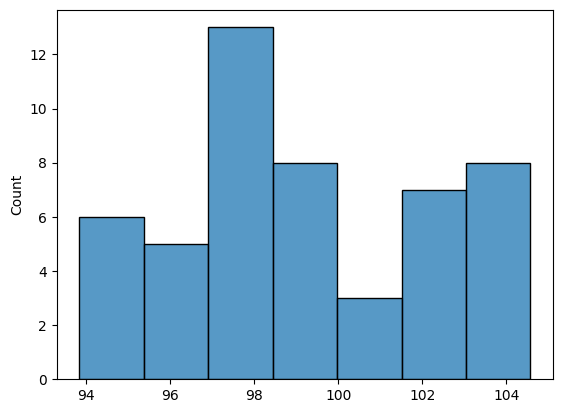

In [334]:
import seaborn as sns
import matplotlib.pyplot as plt

np_scores = np.array(scores)

sns.histplot(np_scores)
plt.show()

In [335]:
best_solution.print_output()

Total Distance 93.8469150809349
Total Cost 123.48026230609698

Vehicle 1 (Type A):
Depot -> C7 (10.161 km) -> C6 (7.011 km) -> C5 (1.234 km) -> C2 (1.265 km) -> Depot (9.072 km)
Round Trip Distance: 28.742 km
Demand: 24
Round Trip Cost: RM 34.49

Vehicle 2 (Type A):
Depot -> C9 (13.336 km) -> C10 (7.120 km) -> Depot (8.436 km)
Round Trip Distance: 28.891 km
Demand: 13
Round Trip Cost: RM 34.67

Vehicle 3 (Type B):
Depot -> C1 (13.152 km) -> C4 (4.021 km) -> C3 (8.323 km) -> C8 (6.557 km) -> Depot (4.161 km)
Round Trip Distance: 36.213 km
Demand: 20
Round Trip Cost: RM 54.32

